In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# you can choose one of the following package for image reading/processing
import cv2
import PIL

## Problem 1. Support Vector Machine (SVM)

In [2]:
# Read data
data_x_ori = pd.read_csv('x_train.csv', header=None)
data_t_ori = pd.read_csv('t_train.csv', header=None)

# Turn dataset into numpy form
data_x = np.array(data_x_ori)
data_t = np.array(data_t_ori)

In [3]:
def pca(x, n_components=2):
    # Data matrix X, assumes 0-centered
    n, m = x.shape
    x_tmp = x - np.mean(x, axis=0)
    
    # Compute covariance matrix
    cov = np.dot(x_tmp.T, x_tmp) / (n - 1)
    
    # Eigen decomposition
    eigen_vals, eigen_vecs = np.linalg.eig(cov)
    
    # Project X onto PC space (with top 2 eigenvectors)
    x_pca = np.dot(x_tmp, eigen_vecs[:, :n_components].real)
    return x_pca

In [4]:
# Use PCA to reduce the dimension
PCA_MODE = 'own'
if PCA_MODE == 'sklearn':
    pca = PCA(n_components=2)
    pca.fit(data_x)
    data_x = pca.transform(data_x)
else:
    data_x = pca(data_x, 2)
data_x = (data_x - np.mean(data_x)) / np.std(data_x)

# Sort the data
train = np.concatenate((data_t, data_x), axis=1)
train_c0 = train[np.where(train[:, 0] == 0)]
train_c1 = train[np.where(train[:, 0] == 1)]
train_c2 = train[np.where(train[:, 0] == 2)]
train = np.concatenate((train_c0, train_c1, train_c2))

train_x = train[:, 1:]
train_t = train[:, 0:1].astype(int)

In [5]:
def kernel_function(xi, xj, kernel_type='linear'):
    phi_xi = feature_space_trans(xi, kernel_type) 
    phi_xj = feature_space_trans(xj, kernel_type)
    
    kernel = np.dot(phi_xi, phi_xj.T)
    return kernel    
    
def feature_space_trans(x, kernel_type='linear'):    
    if kernel_type == 'linear':
        phi_x = x
    else:
        if len(x.shape) == 1:
            x = x.reshape(1,2)
        x1 = x[:, 0].reshape((-1, 1))   # x1: (300, 1)
        x2 = x[:, 1].reshape((-1, 1))   # x2: (300, 1)
        phi_x = np.concatenate((x1 ** 2, np.sqrt(2) * x1 * x2, x2 ** 2), axis=1)
    return phi_x    # phi_x: (300, 3)

def fit(x, t, kernel_type='linear', rls_para=1):
    if kernel_type == 'linear':
        classifier = svm.SVC(kernel='linear', C=rls_para, decision_function_shape='ovo')
    else:
        classifier = svm.SVC(kernel='poly', C=rls_para, degree=2, decision_function_shape='ovo')

    classifier.fit(x, t)
    coeff = np.abs(classifier.dual_coef_) 
    sv_index = classifier.support_ 
    return coeff, sv_index

def target_parameter(classes):
    target_dict = {}
    target_dict[classes[0]] = np.concatenate((np.ones(100), np.full([100], -1), np.zeros(100)))
    target_dict[classes[1]] = np.concatenate((np.ones(100), np.zeros(100), np.full([100], -1)))
    target_dict[classes[2]] = np.concatenate((np.zeros(100), np.ones(100), np.full([100], -1)))
    return target_dict

def alpha_parameter(x, coeff, sv_index, classes):
    alpha = np.zeros((x.shape[0], 2))
    alpha[sv_index] = coeff.T

    alpha_dict = {}
    alpha_dict[classes[0]] = np.concatenate((alpha[:200, 0], np.zeros(100)))
    alpha_dict[classes[1]] = np.concatenate((alpha[:100, 1], np.zeros(100), alpha[200:, 0]))
    alpha_dict[classes[2]] = np.concatenate((np.zeros(100), alpha[100:, 1]))
    return alpha_dict

def weight_parameter(alpha, t, x, kernel_type):
    phi_x = feature_space_trans(x, kernel_type)
    w = np.dot(alpha * t, phi_x)
    return w

def bias_parameter(alpha, t, x, kernel_type):
    C = 1
    M_index = np.where(((alpha > 0) & (alpha < C)))[0]
    S_index = np.nonzero(alpha)[0]

    if len(M_index) == 0:
        b = 0
    else:
        kernel = kernel_function(x[M_index], x[S_index], kernel_type)
        b = np.mean(t[M_index] - np.dot((alpha * t)[S_index], kernel.T))

    return b

def training(x, coeff, sv_index, classes, kernel_type):
    targets = target_parameter(classes)
    alphas = alpha_parameter(x, coeff, sv_index, classes)
    weight_dict = {}
    bias_dict = {}

    for c in classes:
        weight = weight_parameter(alphas[c], targets[c], x, kernel_type)
        bias = bias_parameter(alphas[c], targets[c], x, kernel_type)
        weight_dict[c] = weight
        bias_dict[c] = bias

    return weight_dict, bias_dict

def prediction(x, weights, biases, classes, kernel_type):
    results = []

    for i in range(x.shape[0]):
        votes = []
        for c in classes:
            phi_x = feature_space_trans(x[i], kernel_type)
            w = weights[c]
            b = biases[c]
            y = np.dot(w, phi_x.T) + b

            if y > 0:
                votes.append(c[0])
            else:
                votes.append(c[1])
        
        # Vote for the class
        v = np.array(votes)
        vote_num = np.zeros(3)
        for j in range(len(v)):
            vote_num[j] = np.count_nonzero(v == j)
        elect = np.argmax(vote_num)      
        results.append(elect)
        # results.append(Counter(votes).most_common()[0][0])

    return results

def plot_img(x, t, xx, yy, results, sv_index, kernel_type):
    c0_index = np.where(t == 0)[0]
    c1_index = np.where(t == 1)[0]
    c2_index = np.where(t == 2)[0]

    if kernel_type == 'linear':
        plt.title('Linear Kernel', fontsize = 15)
    else:
        plt.title('Polynomial Kernel of Degree 2', fontsize = 15)
    plt.scatter(x[sv_index, 0], x[sv_index, 1], s=50, facecolors='none', edgecolors='k', linewidths=2, label="support vector")
    plt.scatter(x[c0_index][:, 0], x[c0_index][:, 1], c='b', marker='x', label="character 0")
    plt.scatter(x[c1_index][:, 0], x[c1_index][:, 1], c='r', marker='x', label="character 1")
    plt.scatter(x[c2_index][:, 0], x[c2_index][:, 1], c='g', marker='x', label="character 4")
    plt.contourf(xx, yy, results, alpha=0.2, cmap=plt.cm.brg)
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


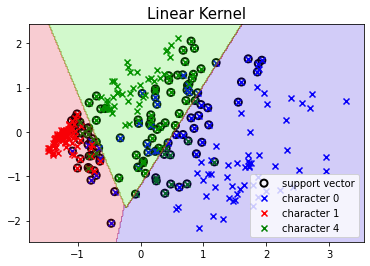

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


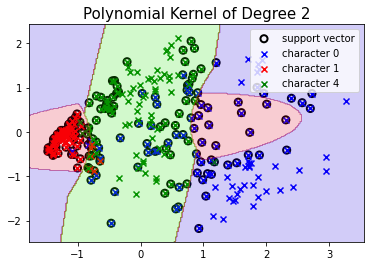

In [6]:
kernel_types = ['linear', 'poly']
C = 1
classes = [(0, 1), (0, 2), (1, 2)]
sp = 0.3 # space
h = 0.02
for k in kernel_types:
    weight_dict = {}
    bias_dict = {}
    coeff, sv_index = fit(train_x, train_t, k)
    weight_dict, bias_dict = training(train_x, coeff, sv_index, classes, k)

    xx, yy = np.meshgrid(np.arange(min(train_x[:, 0]) - sp, max(train_x[:, 0]) + sp, h), 
                        np.arange(min(train_x[:, 1]) - sp, max(train_x[:, 1]) + sp, h))
    results = prediction(np.hstack((xx.reshape((-1,1)), yy.reshape((-1,1)))), weight_dict, bias_dict, classes, k)
    plot_img(train_x, train_t, xx, yy, np.array(results).reshape(xx.shape), sv_index, k)

## Problem 2. Gaussian Mixture Model

In [7]:
image = cv2.imread('hw3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, channel = image.shape    # 410, 615, 3
image = np.reshape(image, (-1, channel))    # image: (252150, 3)
image = image / 255.0

In [8]:
def indicator(x, u):
    r_nk = np.zeros((x.shape[0], u.shape[0]))

    for n in range(x.shape[0]):
        dists = []
        for k in range(u.shape[0]):
            # distance^2 = (x_x - u_x)^2 + (x_y - u_y)^2 + (x_z - u_z)^2
            dists.append(np.sum((x[n] - u[k]) ** 2))
        d_min = np.argmin(dists)
        r_nk[n][d_min] = 1.0
    return r_nk

def center_updating(x, r_nk):
    u_k_new = []

    for k in range(r_nk.shape[1]):
        r_n = r_nk[:, k:(k + 1)]
        r_tmp = np.hstack((r_n, r_n, r_n))

        sum_rx = np.sum(r_tmp * x, axis=0)
        sum_r = np.sum(r_n, axis=None)

        u_k_new.append((sum_rx / sum_r))

    return u_k_new

In [9]:
def initialization(x, u, r_nk, K):
    # Pi parameter
    N_k = np.sum(r_nk, axis=0)
    pi = N_k / r_nk.shape[0]    

    # Sigma parameter
    covariance = np.array([np.cov(x[np.where(r_nk[:, k] == 1)[0]].T) for k in range(K)])  
    pi_sigma = np.array([multivariate_normal.pdf(x, mean=u[k], cov=covariance[k]) * pi[k] for k in range(K)])
    return covariance, pi_sigma    # pi: (K, ) / covariance: (K, D, D) / sigma: (K, N)

def E_step(pi_sigma, K):
    # Gamma parameter
    gamma = (pi_sigma / np.sum(pi_sigma, axis=0)).T
    return gamma    # gamma: (N, K)

def M_step(x, gamma, covariance, pi_sigma, K):
    # Pi parameter
    N_k = np.sum(gamma, axis=0) 
    pi = N_k / len(x)

    # Mu parameter
    mu = np.array(center_updating(x, gamma))
    
    # Sigma parameter
    for k in range(K):
        covariance[k] = (gamma[:, k, np.newaxis] * (x - mu[k])).T.dot(x - mu[k]) / N_k[k]
        pi_sigma[k] = multivariate_normal.pdf(x, mean=mu[k], cov=covariance[k], allow_singular=True) * pi[k]

    return mu, covariance, pi_sigma
    
def log_likelihood(pi_sigma, K):
    likelihood = np.sum(np.log(np.sum(pi_sigma, axis=0)))
    return likelihood

In [10]:
def print_table(u, model_type, K):
    u_pixel = u * 255.0
    print("============= K = %d (%s) =============" % (K, model_type))
    print("%-8s|       R           G           B" % (model_type))
    for k in range(K):
        print("%-8d|  %10f  %10f  %10f" % (k, u_pixel[k][0], u_pixel[k][1], u_pixel[k][2]))

def plot_img(u, r_nk, gauss, img_size, model_type, K):
    height, width, channel = img_size
    if model_type == 'K_means':
        new_img = np.array(u)[np.where(r_nk == 1)[1]]
    else:
        new_img = np.array(u)[np.argmax(gauss, axis=0)]

    show_img = (new_img * 255.0).reshape((height, width, channel)).astype(int)
    plt.title('K = ' + str(K) + ' (' + str(model_type) + ')', fontsize = 14)
    plt.imshow(show_img)
    plt.show()

def plot_log_likelihood(likelihoods, K, max_iter=100):
    plt.title('Log likelihood of GMM (K = %d)' % K, fontsize = 14)
    plt.xlabel("Iteration number", fontsize = 10)
    plt.ylabel("Log likelihood", fontsize = 10)
    plt.plot(np.arange(max_iter), likelihoods)
    plt.show()
    print('\n\n')

============= K = 3 (K_means) =============
K_means |       R           G           B
0       |   83.301501   89.287982   61.469566
1       |  219.016888  227.318236  237.348431
2       |  177.528148  187.179286  192.472540


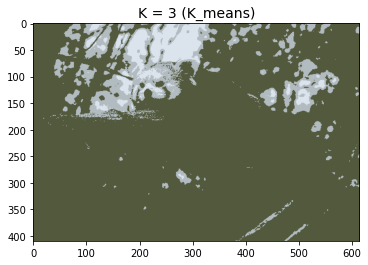

============= K = 3 (GMM) =============
GMM     |       R           G           B
0       |   45.105518   30.008327   21.370049
1       |  178.427166  192.440607  203.413912
2       |  106.372496  121.537871   83.552863


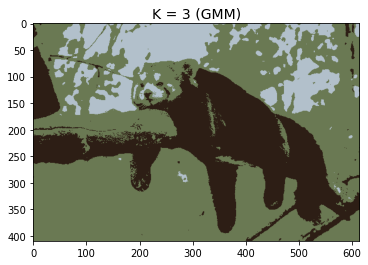

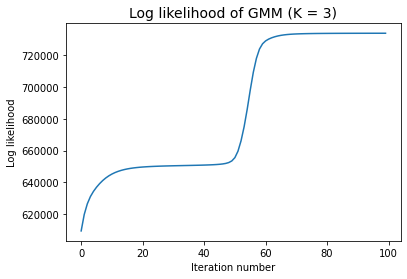




============= K = 7 (K_means) =============
K_means |       R           G           B
0       |  110.354851  124.338525   89.153460
1       |  173.672988  188.363997  186.918417
2       |   85.862989   99.037432   48.343169
3       |  155.090436  145.372397  135.330804
4       |   20.882914   14.888163   11.118372
5       |   46.913415   38.905238   24.733357
6       |    9.322774    6.956292    4.769102


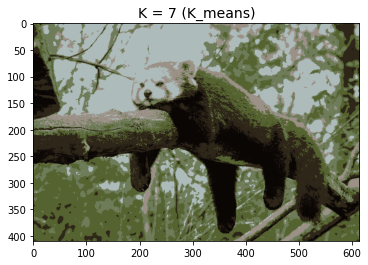

============= K = 7 (GMM) =============
GMM     |       R           G           B
0       |  136.614692  155.814121  147.258970
1       |  199.929998  212.328116  225.875717
2       |   93.606895  111.927325   65.056481
3       |  164.049792  156.432501  151.631650
4       |   31.957027   27.729005   21.480022
5       |   93.864497   50.573205   32.889151
6       |    9.716307    7.522104    5.877347


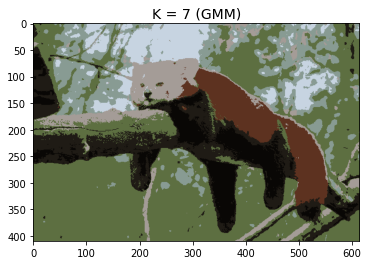

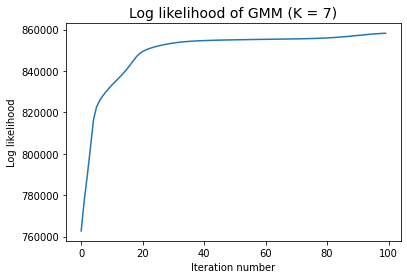




============= K = 10 (K_means) =============
K_means |       R           G           B
0       |   68.662239  103.387267   33.201647
1       |   15.363542   11.152707    7.242570
2       |  134.375204  140.031836  103.791678
3       |   68.619962  110.215819   10.945009
4       |   70.900129   66.415591   42.513723
5       |   43.244774   33.640467   23.044755
6       |   97.390644  112.583402   68.910070
7       |  214.274320  222.258976  231.687601
8       |  180.005089  190.432318  197.548880
9       |  147.030773  159.345294  159.695546


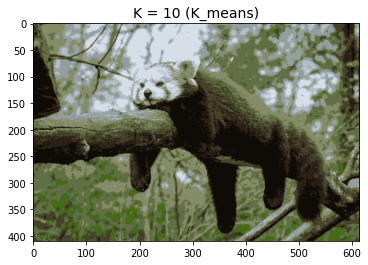

============= K = 10 (GMM) =============
GMM     |       R           G           B
0       |   58.409330   74.265866   34.011640
1       |    9.634013    7.464766    5.734426
2       |  174.450027  123.447809   88.537882
3       |   85.851643  122.351935   51.447583
4       |   83.364687   43.459939   28.100317
5       |   30.767390   26.355399   20.719763
6       |  101.342877  111.536077   76.992432
7       |  201.940773  214.134291  227.677980
8       |  166.468315  160.534243  158.772230
9       |  140.987502  160.044988  157.552348


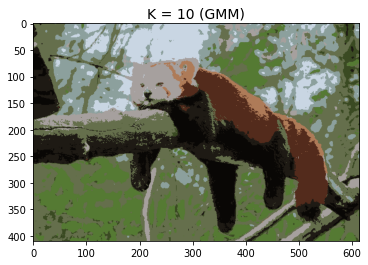

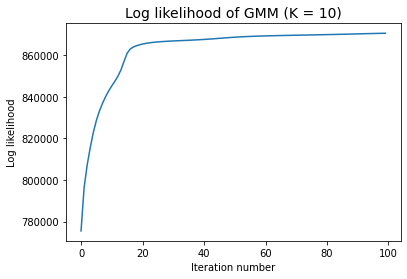




============= K = 30 (K_means) =============
K_means |       R           G           B
0       |  123.337384  144.039648  101.715024
1       |  132.692887  152.223431  148.257462
2       |  110.479459  122.098468  120.101076
3       |   28.274262   20.250422   11.085229
4       |  163.081698  178.767930  186.444012
5       |  120.925265  134.385027   79.266165
6       |   65.370568   51.836942   35.560239
7       |   47.183333   39.873700   18.139144
8       |  165.710779  162.837424  160.247243
9       |  206.126478  198.282776  191.748072
10      |    9.295592    6.755864    4.008796
11      |  192.933967  179.832203  166.397558
12      |   98.248073  130.653931   61.402641
13      |  150.796775  157.800466  146.312804
14      |  175.479098  192.161891  204.404102
15      |   73.369779   80.758279   58.398717
16      |  113.190942  139.639218   88.706296
17      |   29.607102   24.780398   20.129830
18      |  126.296011   72.038177   48.503419
19      |   79.444735  111.760749   

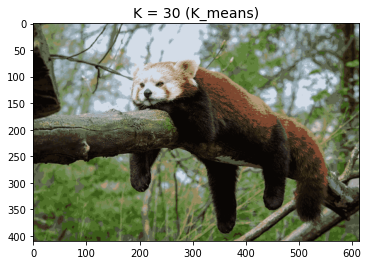

============= K = 30 (GMM) =============
GMM     |       R           G           B
0       |  122.107870  142.394089  101.026572
1       |  136.057342  156.164174  145.320311
2       |  128.494025  122.811454  115.898879
3       |   16.688274   12.519716    7.066226
4       |  158.881970  177.923867  181.341318
5       |  115.958028  127.353080   82.743420
6       |   40.512707   35.754233   24.632913
7       |   37.837618   46.080296   19.650100
8       |  166.533743  159.802931  162.235317
9       |  218.012008  214.373024  214.095330
10      |    6.588526    4.652602    0.248103
11      |  204.174242  176.348885  152.556505
12      |   93.893803  128.647819   60.275373
13      |  160.082503  146.051042  120.992066
14      |  184.625000  199.113424  213.755406
15      |   78.972669   77.128517   61.246964
16      |  112.282017  143.634900   76.456170
17      |   15.686883   13.282342   11.998834
18      |   90.931621   48.419297   32.627449
19      |   80.535380  110.352664   50.1355

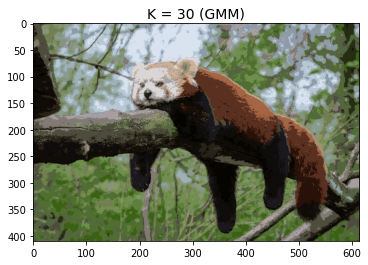

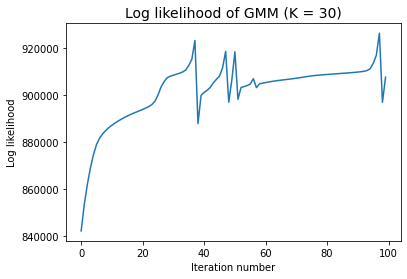

In [11]:
K_centers = [3, 7, 10, 30]
MAX_ITERATION = 100
image_size = [height, width, channel]

for K in K_centers:
    # Initial conditions
    u = image[np.random.choice(len(image), K, replace=False)]

    # K-means
    for _ in range(MAX_ITERATION):
        r_nk = indicator(image, u)
        u_k_new = np.array(center_updating(image, r_nk))
        
        if (u_k_new == u).all:
            break
        else:
            u = u_k_new
    
    print_table(u_k_new, 'K_means', K)
    plot_img(u_k_new, r_nk, 0, image_size, 'K_means', K)

    # GMM
    covariance, pi_sigma = initialization(image, u_k_new, r_nk, K)
    likelihoods = []

    for _ in range(MAX_ITERATION):
        gamma = E_step(pi_sigma, K)
        mu, covariance, pi_sigma = M_step(image, gamma, covariance, pi_sigma, K)
        likelihoods.append(log_likelihood(pi_sigma, K))

    print_table(mu, 'GMM', K)
    plot_img(mu, gamma, pi_sigma, image_size, 'GMM', K)
    plot_log_likelihood(likelihoods, K)